Tulemuseks on rakendus (pakitud ühte zip-faili, valmisprogramm koos programmikoodi ja vajadusel installeerimisjuhendiga) ja töö kirjeldus eraldi pdf-failis:

Pealkiri
Töö eesmärk ja tehisintellekti kasutamise vajadus
Kasutatud ideed (nii kursuse materjalidest kui mujalt) koos viidetega
Iga autori enda panuse kirjeldus
Programmi testimisvõimalused ja vähemalt mõned testimistulemused
Töö käigu kirjeldus: millised olid probleemid, mis õnnestus, mis jäi realiseerimata jne (kirjeldatud probleemid ega puudused ei mõju hindele kuidagi negatiivselt)

Hindame:
Idee originaalsust
Lahenduse mahtu ja keerukust (ootame kodutöödega võrreldavas mahus tööd)
Tehisintellekti kasutamise mõttekust ja resultatiivsust
Disaini ja kasutajamugavust

# ASL tähtede tuvastamine videost

Projekti kirjeldus siia.

Kasutaja Keegan Moore on Kaggle dataseti discussionsi alla kirjutanud, et mõni täht selles andmestikud ei ole ASL-ist. Väidetavalt on tähed G, K, T, M, N, P mingist teisest keeleset. Kuna meil ei ole teadmisi ASL-i kohta, siis lisame selle andmestiku põhjal saadud tähestikust pildi, mida kasutaja kasutama peaks, et tema viipeid ära tuntaks. Siin on selle andmehulga järgi ASL tähestik. 

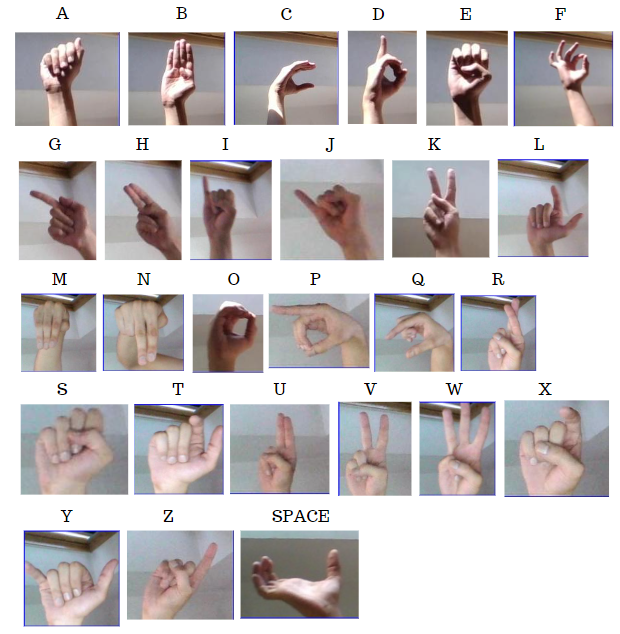

Rühmaliikmed: Lauri Lüüsi, Veronika Kukk

Meie idee on kasutada masinõpet, et tuvastada ASL tähemärke ja neid kasutajale ette lugeda. 

1. Treenime mudeli tundma ära ASL tähti Kaggle andmestiku abil.

2. Kasutaja näitab kaamerale käemärke, käemärgid tehakse tekstiks.

3. Kasutaja näidatud käemärgid loetakse kasutajale ette (kõnesüntees).



Sellise projekti abil saaks kasutaja ASL tähti õppida või näha, kas tema viiped on piisavalt korralikud, et mudel seda ära tunneks. 

Kavatseme kasutada Kaggle andmestiku https://www.kaggle.com/datasets/grassknoted/asl-alphabet

### Impordid

In [124]:
import numpy as np
import pandas as pd

# video
import cv2 as cv
import time

# kõnesüntees
# from gtts import gTTS
import IPython.display as ipd
# import sounddevice as sd
# import soundfile as sf

# vb ajutine
import matplotlib.pyplot as plt

# mudel
import tensorflow as tf
from tensorflow import keras
import pathlib
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Rescaling, MaxPooling2D, Flatten

### Abifunktsioonid

In [2]:
def imageCrop(img):
    # võtab sisendiks (veebikaamera) pildi ja tagastab 200x200 suuruses lõike pildi keskelt (sama suure nagu treeninghulgas)
    height, width, _ = img.shape
    
    side = min(height, width)
    start_x = (width - side) // 2
    start_y = (height - side) // 2
    cropped_img = img[start_y:start_y+side, start_x:start_x+side, :]
    resized_img = cv.resize(cropped_img, (200, 200))

    return resized_img

In [21]:
def loeEtte(text):
    # keel on en, sest ASL on inglisekeelne
    lause = gTTS(text=text, lang='en', slow=False)
    lause.save('lause.wav')
    # esitame kasutajale tema viibatud sõna
    audio, fs = sf.read('lause.wav', dtype='float32')
    sd.play(audio, fs)

### Andmete import

In [4]:
train_kaust = pathlib.Path('asl_alphabet_train/')

test_kaust = pathlib.Path('asl_alphabet_test/')

### Mudelite ettevalmistus

In [5]:
batch_size = 32
img_height = 200
img_width = 200

train = tf.keras.utils.image_dataset_from_directory(
    train_kaust,
    labels='inferred',
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

# test kaustas on ainult 1 pilt iga viipe kohta, seega seda ei saa kasutada valideerimiseks
val = tf.keras.utils.image_dataset_from_directory(
    train_kaust,
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 81000 files belonging to 27 classes.
Using 64800 files for training.
Found 81000 files belonging to 27 classes.
Using 16200 files for validation.


In [6]:
mudel1 = Sequential()
mudel1.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
mudel1.add(Dense(128, activation="relu"))
mudel1.add(Conv2D(64, 3, padding="same", activation="relu"))
mudel1.add(MaxPooling2D())
mudel1.add(Flatten())
mudel1.add(Dense(len(train.class_names)))

In [7]:
mudel2 = Sequential()
mudel2.add(Dense(128, input_shape=(img_height, img_width, 3)))
mudel2.add(Conv2D(64, 3, padding="same", activation="relu"))
mudel2.add(MaxPooling2D())
mudel2.add(Flatten())
mudel2.add(Dense(64, activation="relu"))
mudel2.add(Dense(32, activation="relu"))
mudel2.add(Dense(len(train.class_names)))

In [8]:
mudel3 = Sequential()
mudel3.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
mudel3.add(Dense(128, activation="sigmoid"))
mudel3.add(Conv2D(64, 3, padding="same", activation="sigmoid"))
mudel3.add(MaxPooling2D())
mudel3.add(Flatten())
mudel3.add(Dense(len(train.class_names)))

### Mudeli treenimine

In [ ]:
# eraldi failis sest see oli liiga suur

In [189]:
model = tf.keras.models.load_model('mudel.h5')

In [245]:
# näide
results = []
labels = train.class_names

for label in labels:
    # võtame test hulgast pildi
    image = cv.imread(f'asl_alphabet_train/{label}/{label}98.jpg')
    image = tf.expand_dims(image,0)

    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions, axis=1)
    predicted_class = labels[predicted_class_index[0]]

    array = predictions[0]
    mean = np.mean(array)
    std = np.std(array)
    normalized_array = (array - mean) / std

    predicted_class = labels[predicted_class_index[0]]
    results += [f"tegelik: {label} | predicted: {predicted_class} | {label == predicted_class}"]
    
for res in results:
    print(res)

1/1 [==============================] - 0s 43ms/step
tegelik: A | predicted: W | False
tegelik: B | predicted: O | False
tegelik: C | predicted: Z | False
tegelik: D | predicted: L | False
tegelik: E | predicted: O | False
tegelik: F | predicted: F | True
tegelik: G | predicted: G | True
tegelik: H | predicted: P | False
tegelik: I | predicted: O | False
tegelik: J | predicted: N | False
tegelik: K | predicted: W | False
tegelik: L | predicted: C | False
tegelik: M | predicted: M | True
tegelik: N | predicted: O | False
tegelik: O | predicted: O | True
tegelik: P | predicted: P | True
tegelik: Q | predicted: Q | True
tegelik: R | predicted: W | False
tegelik: S | predicted: Z | False
tegelik: T | predicted: X | False
tegelik: U | predicted: W | False
tegelik: V | predicted: W | False
tegelik: W | predicted: W | True
tegelik: X | predicted: X | True
tegelik: Y | predicted: Y | True
tegelik: Z | predicted: Z | True
tegelik: space | predicted: space | True


### Programm

In [29]:
# lisame ülesse mustale taustale teksti, et oleks kergem lugeda
bar = np.zeros((60,320, 3), dtype=np.uint8)
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_FRAME_WIDTH, 200)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 200)

text = "cats"

start_time = time.time()

while True:
    ret, img = cap.read()
    current_time = time.time()
    viibe = ''
    elapsed_time = current_time - start_time
    # 5 naitab mitme sekundi tagant sisendit lugeda
    if elapsed_time >= 5:
        # SIIA panna kood, mis predictib, mis viibe on hetkel
        viibe = 'space' # detectASL(img)
        start_time = current_time
        text='cats'
    # paneme ekraanile kogu aeg seni loetud texti
    img = np.concatenate((bar, img), axis=0)
    cv.putText(img, text, (10, 40), cv.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
    cv.imshow("img", img)
    
    if viibe == 'space' and text!='':
        loeEtte(text)
        text = ""
    else:
        text += viibe
    
    k = cv.waitKey(30) & 0xFF
    if k == 27: # Escape klahv
        break
    
cap.release()
cv.destroyAllWindows()